#  Анализ вероятности оттока клиентов сети фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. 

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся. 

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. **Задача — провести анализ и подготовить план действий по удержанию клиентов**.  
А именно: 
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
  - выделить целевые группы клиентов;
  - предложить меры по снижению оттока;
  - определить другие особенности взаимодействия с клиентами.

**Описание данных**

«Культурист-датасаентист» предоставил сведения в csv-файле `/datasets/gym_churn.csv`. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

## Исследовательский анализ данных (EDA)

### 1.1 Анализ качества признаков

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

pd.set_option('display.max_colwidth', None)

In [2]:
gymchurn = pd.read_csv ('/datasets/gym_churn.csv') # загрузка данных

In [3]:
gymchurn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# приведение названий столбцов к нижнему регистру
gymchurn.columns = gymchurn.columns.str.lower()
gymchurn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [5]:
# размер датасета
gymchurn.shape

(4000, 14)

In [6]:
gymchurn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Все признаки численные. Пропуски отсутствуют.

In [7]:
round (gymchurn.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


Данные равномерные, стандартные отклонения не слишком далеко от средних. Выбросов не наблюдается.

### Анализ средних значений признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [8]:
round(gymchurn.groupby('churn').mean(),2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Клиенты, которые проживают или работают ближе к фитнес-центру оттекают немного меньше. 

Сотрудники компаний-партнёров клуба и те, кто пришел по акции "приведи друга" более лояльны и оттекают меньше.

У действующих клиентов срок действия абонемента дольше, чем у ушедших. А также времени до окончания абонемента больше. Высокое влияние признака на отток.

Действующие клиенты чаще посещают групповые занятия.

Средний возраст действующих клиентов 30 лет, а средний возраст ушедших чуть меньше - 27 лет.

Суммарная выручка от других услуг фитнес-центра (кафе, спорттовары, косметический и массажный салон) выше от действующих пользователей (158 едениц), чем у ушедших (115 едениц).

Средняя частота посещений у действующих клиентов выше, они чаще посещают зал, чем ушедшие клиенты.

Признак пола и телефона не влияет на отток.

### Cтолбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

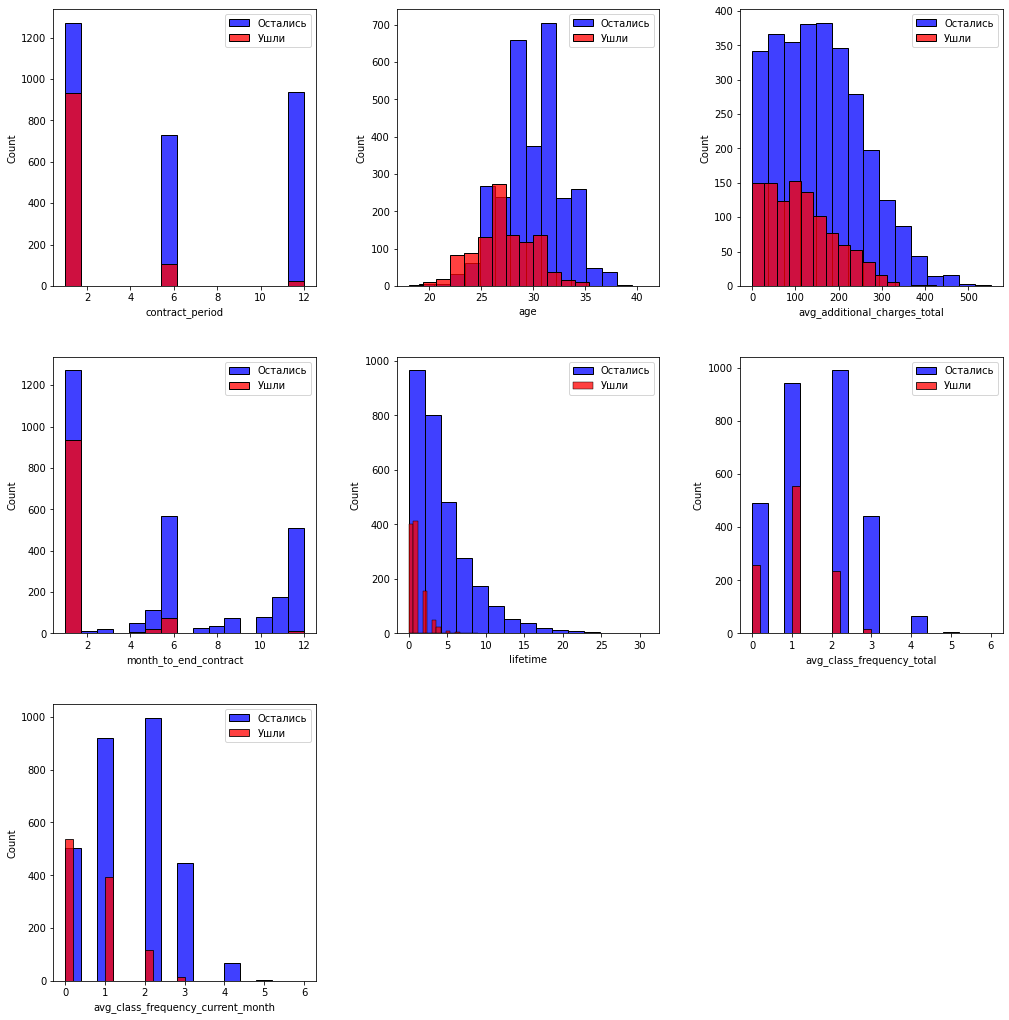

In [9]:
values = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 
          'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

# Определяем количество строк и столбцов
nrows = (len(values) + 1) // 2  # Округляем вверх
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes_list = [item for sublist in axes for item in sublist]  # Преобразуем в одномерный список
fig.tight_layout(pad=5.0)

for feature in values:
    ax = axes_list.pop(0)  

    sns.histplot(gymchurn.query('churn == 0')[feature].astype(int), bins=15, ax=ax, color='b', label='Остались', kde=False)
    sns.histplot(gymchurn.query('churn == 1')[feature].astype(int), bins=15, ax=ax, color='r', label='Ушли', kde=False)

    ax.set_xlabel(feature)
    ax.legend()
    
for remaining_ax in axes_list:
    remaining_ax.remove()

plt.show()

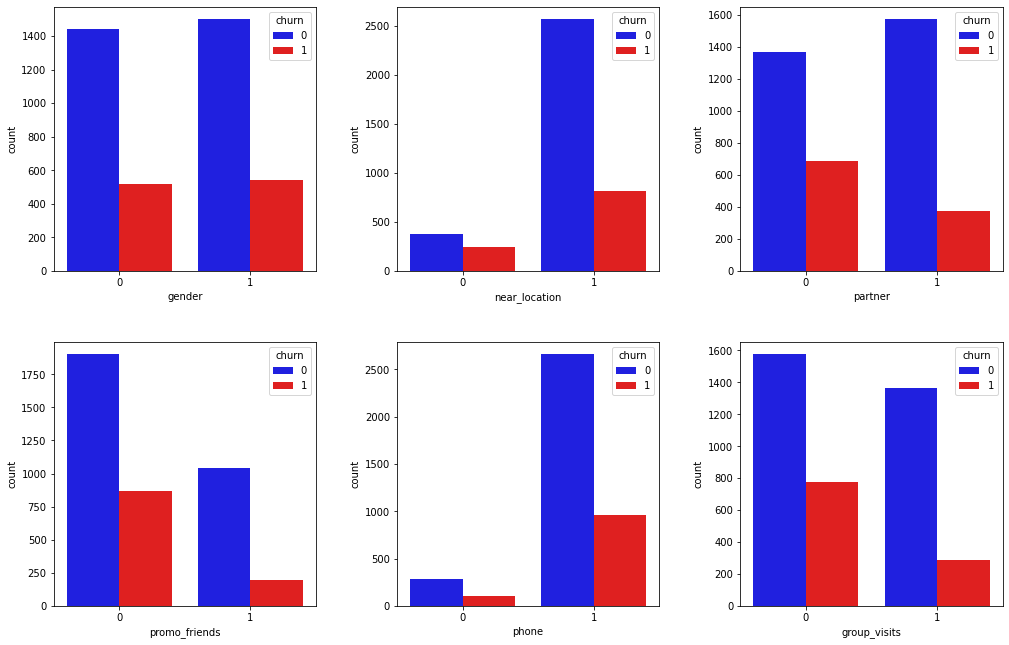

In [10]:
values = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

nrows = (len(values) + 2) // 3 
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 5 * nrows))
axes_list = [item for sublist in axes for item in sublist]
fig.tight_layout(pad=5.0)

for feature in values:
    ax = axes_list.pop(0)  

    sns.countplot(data=gymchurn, x=feature, hue='churn', ax=ax, palette={0: 'b', 1: 'r'})
    
    ax.set_xlabel(feature)
    
plt.show()

- Доли оттока у представителей разного пола примерно одинаковые.
- Клиентов, проживающих или работающих ближе к залу больше, доля оттока среди них меньше. У проживающих дальше очень высокий отток.
- Сотрудники компаний-партнёров клуба больше и доля оттока меньше.
- Клиентов, пришедших по акции "приведи друга", меньше, но доля их оттока тоже ниже, чем у отстальных клиентов.
- На групповые занятия ходит меньше действующих посетителей, но среди них низкий отток.
- Большинство ушедших клиентов имеют абонемент на 1 мес. (чем больше срок, тем ниже отток).
- В возрасте до 28 лет оттекает больше клиентов, чем старше клиенты, тем они более лояльны.
- Клиенты, у которых осталось меньше 2-ух мес. до окончания абонемента имеют высокий отток, чем больше срок до окончания, тем меньше отток.
- У клиентов с большим сроком с момента покупки абонемента отток ниже. Большинство оттекает в первые месяцы.
- Чем чаще ходит клиент в зал, тем ниже отток.

### Матрица корреляций

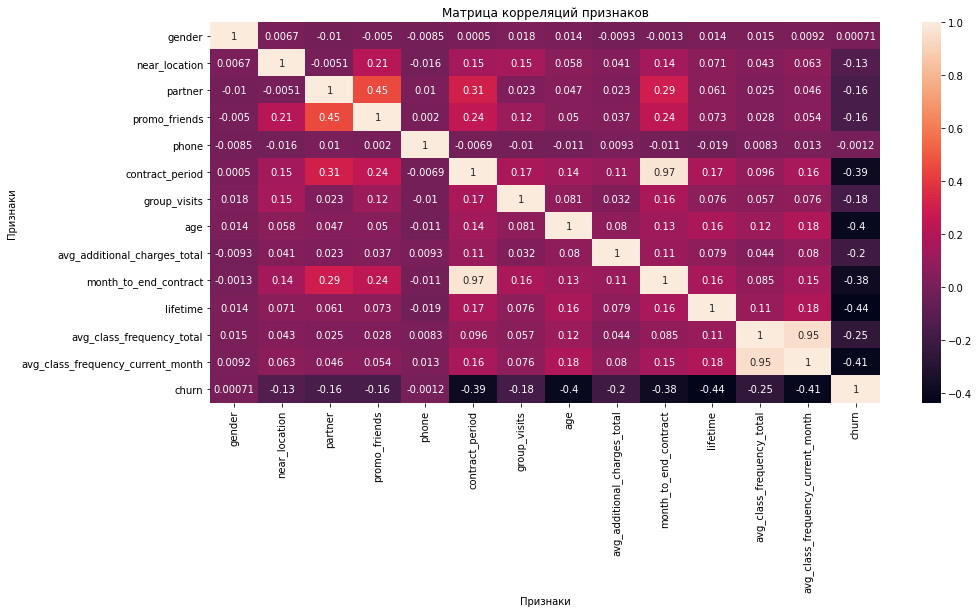

In [11]:
cm = gymchurn.corr()  #вычисляем матрицу корреляций
plt.figure(figsize=(15,7))
sns.heatmap(cm, annot = True, square=False)
plt.title('Матрица корреляций признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

Характеристики имеют слабую корелляцию. Значительную кореляцию имеют только признаки: 
- contract_period и month_to_end_contract (чем больше срок дейсвия абонемента, тем больше дней до его окончания); 
- avg_class_frequency_total и avg_class_frequency_current_month (кто чаще ходит в зал на неделе, тот чаще ходил за весь период действия абонемента).

**Промежуточный вывод**

В ходе EDA анализа установлено:
- Размер датасета (4000, 14).
- Все признаки численные. Пропуски отсутствуют.
- Данные равномерные, стандартные отклонения не слишком далеко от средних. Выбросов не наблюдается.

Изучение показателей оттока клиента:
- Доли оттока у представителей разного пола примерно одинаковые.
- Клиентов, проживающих или работающих ближе к залу больше, доля оттока среди них меньше. У проживающих дальше очень высокий отток.
- Сотрудники компаний-партнёров клуба больше и доля оттока меньше.
- Клиентов, пришедших по акции "приведи друга", меньше, но доля их оттока тоже ниже, чем у отстальных клиентов.
- На групповые занятия ходит меньше действующих посетителей, но среди них низкий отток.
- Большинство ушедших клиентов имеют абонемент на 1 мес. (чем больше срок, тем ниже отток).
- В возрасте до 28 лет оттекает больше клиентов, чем старше клиенты, тем они более лояльны.
- Клиенты, у которых осталось меньше 2-ух мес. до окончания абонемента имеют высокий отток, чем больше срок до окончания, тем меньше отток.
- У клиентов с большим сроком с момента покупки абонемента отток ниже. Большинство оттекает в первые месяцы.
- Чем чаще ходит клиент в зал, тем ниже отток.

Признаки слабо коррелируют между собой, кроме двух логических пар признаков (contract_period и month_to_end_contract (чем больше срок дейсвия абонемента, тем больше дней до его окончания); avg_class_frequency_total и avg_class_frequency_current_month (кто чаще ходил каждый меньше, тот чаще ходил за весь период действия абонемента)).

## Модель прогнозирования оттока клиентов

Построение модели бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

### Выделение обучающей и валидационной выборок

In [12]:
#разделение данных на признаки (матрица X) и целевую переменную (y)
X = gymchurn.drop('churn', axis=1)
y = gymchurn['churn']

In [13]:
# разделение модели на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Стандартизация данных

In [14]:
#создание объекта класса StandardScaler и применение к обучающей выборке
scaler = StandardScaler()
X_train_st =  scaler.fit_transform(X_train) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

### Обучение модели на train-выборке двумя способами: логистической регрессией, случайным лесом.

In [15]:
# алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучение модеи
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

In [16]:
# алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(random_state = 0) # Ваш код здесь
# обучение модели случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1] 

### Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнение по ним модели.

In [17]:
# определенние функции, которая будет выводить метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [18]:
# код ревьюера
# определенние функции, которая будет выводить метрики
def print_all_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
    
print_all_metrics(
    y_test,
    lr_predictions,
    title='Метрики для модели логистической регрессии:'
)    

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


In [19]:
# выведем все метрики логистической регрессии
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:'
)

TypeError: print_all_metrics() got multiple values for argument 'title'

In [ ]:
# выведем все метрики для модели случайного леса
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Значения метрик в обоих моделях сопоставимы.

Метрика Accuracy не отличается в обоих моделях, высокий показатель доли правильных ответов - 92%.

Метрика Precision (точности) - доля правильных ответов только среди целевого класса 84-85%.

Метрика Recall (полноты) - сколько реальных объектов "1" класса смогли обнаружить 81-83%.

## Кластеризация клиентов

### Стандартизация данных

In [ ]:
# откладываем в сторону столбец с оттоком 
X = gymchurn.drop('churn', axis=1)

In [ ]:
# стандартизация данных
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Матрица расстояний функцией linkage() и дендрограмма

In [ ]:
# в переменной linked сохранена таблица «связок» между объектами, её можно визуализировать как дендрограмму
linked = linkage(X_sc, method = 'ward')

In [ ]:
# строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show()

По дендрограмме можно выделить от 4 до 6 кластеров. В расчетах будем использовать значение равное 5.

###  Обучение модели кластеризации на основании алгоритма K-Means и прогнозирование кластеров клиентов

In [ ]:
km = KMeans(n_clusters=5, random_state=0) # число кластеров = 5,фиксирование значения random_state для воспроизводимости результата
labels = km.fit_predict(X_sc) # применение алгоритма к данным и формирование вектора кластеров 

In [ ]:
# сохранение меток кластера в поле датасета
gymchurn['cluster_km'] = labels

### Средние значения признаков для кластеров

In [ ]:
# вывод статистики по средним значениям признаков по кластерам
cluster_features = gymchurn.groupby('cluster_km').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster_km']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

In [ ]:
# кол-во клиентов в каждом кластере
gymchurn.groupby(['cluster_km'])['gender'].count()

**0-ой кластер:** попало 1 010 клиентов, из которых 96% проживают или работают рядом с фитнес-залом, 78% пришли по партнерской программе (больше, чем в других кластерах), 57% - пришли по акции "приведи друга" (больше, чем в других кластерах), 54% посещают групповые тренировки, имеют самую  большую длительность абонементов и lifetime, чаще других посещают зал.

**1-ый кластер:** попало 385 клиентов, из которых 86% проживают или работают рядом с фитнес-залом, 47% пришли по партнерской программе, 31% - пришли по акции "приведи друга", 43% посещают групповые тренировки, период абонемента 5 мес.,  никто не оставил номер телефона.

**2-ой кластер:** попало 505 клиентов, из которых все проживают или работают далеко от фитнес-зала, 46% пришли по партнерской программе,8% - пришли по акции "приведи друга" (самое низкое значени среди кластеров), 22% посещают групповые тренировки (самое низкое значени среди кластеров), период абонемента 2 мес..

**3-ий кластер:** попало 1 262 клиента, из которых все проживают или работают рядом с фитнес-залом, 35% пришли по партнерской программе (самое низкое значени среди кластеров), 24% - пришли по акции "приведи друга", 34% посещают групповые тренировки, меньше всех потратили на доп.услуги, самая низкая длительность абонемента, самая низкая частота посещений в неделю (около 1)

**4-ый кластер:** попало 838 клиентов, из которых 98% проживают или работают рядом с фитнес-залом, 36% пришли по партнерской программе, 23% - пришли по акции "приведи друга", 47% посещают групповые тренировки, больше всех потратили на доп.услуги, самый высокий средни возраст и наибольшая частота посещений.

В 0-ой и 4-ый кластеры попали наиболее лояльные клиенты, у них отток ниже, чем в других кластерах. В основном это клиенты со средним возрастом 30 лет, проживающие или работающие рядом с фитнес-залом, больше всех тратят на доп.услуги, посещают зал около 2 раз в неделю.

### Распределение признаков для кластеров

In [ ]:
# Построим график для логических и дискретных величин
values = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period',\
'group_visits', 'churn']

fig, ax = plt.subplots()

for column in values:
    
    sns.countplot(data=gymchurn, x=column, hue='cluster_km')
   
    plt.title(column)
    plt.xlabel('Распределение')
    plt.ylabel('Количество клиентов')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

Для всех кластеров распределение по признаку "пол" разделилось примерно одинаково. 

Клиенты из 0,1,3 и 4 кластеров живут или работают рядом с фитнес-центром, а в кластере 2 - те, кто живет далеко.

Большинство клиентов из кластера 0 пришли по партнерской программе или акции "приведи друга". А из кластера 3 таких клиентов меньше.

Клиенты, с длительностью текущего действующего абонемента 12 мес. в основном в 0-ом кластере.

In [ ]:
values = ['age', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total',\
         'month_to_end_contract']

fig, ax = plt.subplots()

for column in values:
    
    sns.boxplot(data=gymchurn, x='cluster_km', y=column)
    
    plt.title(column)
    plt.xlabel('кластер')
    plt.ylabel(column)
    plt.show()

Средний возраст клиентов 0-ого и 4-ого кластеров выше, чем у других.

В 3-ем кластере клиенты с наименьшим lifetime, они реже посещают зал на неделе. Они же тратят меньше денег на доп. услуги.

У клиентов в 0-ом кластере осталось больше времени до окончания абонемента.

 ### Доля оттока для кластеров

In [ ]:
part_churn = gymchurn.query('churn==1').groupby('cluster_km')['churn'].count() / gymchurn.query('churn==1')['churn'].count()*100
part_churn

Наибольший отток в 3-ем кластере (61,1%), а наименьший в 0-ом кластере (2,6%).

**Промежуточный вывод**:

Самые низкий отток в 0-ом (2,6%) и 4-ом (5,4%) кластерах. Для таких клиентов характерно:
- проживание или работа рядом с фитнес-залом
- участие в партнерской программе или акции "приведи друга"
- выбор абонемента на более длительный срок
- посещение груповых тренировок
- средний возраст 30 лет
- посещение зала 1-3 раза в неделю


В 3-ем (61,1%) и 2-ом (21,2%) кластере клиенты с наибольшим оттоком, для них характерно:
- посещение груповых тренировок
- выбор абонемента на короткий срок
- средний возраст 28 лет (меньше, чем у более лояльных клиентов)
- посещение зала 1 раз в неделю
- меньшие траты на доп. услуги

## Выводы и рекомендации по работе с клиентами

В ходе исследования была изучена общая информация о клиентах сети фитнес-центров «Культурист-датасаентист» и проведен анализ основных признаков, наиболее сильно влияющих на отток.

В результате **обзора и подготовки данных** определено, что данные предствлены в полном обьеме, отсутсвуют пропущенные значения. Числовые данные равномерные, стандартные отклонения не слишком далеко от средних. Выбросов не наблюдается. Размер датасета достаточен для проведения исследовательского анализа.

**Исследовательский анализ данных (EDA):**

В результате исследования средних значений признаков в двух группах — тех, кто ушел в отток и тех, кто остался сделаны следующие выводы:

- Доли оттока у представителей разного пола примерно одинаковые.
- Клиентов, проживающих или работающих ближе к залу больше, доля оттока среди них меньше. У проживающих дальше очень высокая доля оттока.
- Сотрудники компаний-партнёров клуба больше и доля оттока меньше.
- Клиентов, пришедших по акции "приведи друга", меньше, но доля их оттока тоже ниже, чем у отстальных клиентов.
- На групповые занятия ходит меньше действующих посетителей, но среди них низкий отток.
- Большинство ушедших клиентов имеют абонемент на 1 мес. (чем больше срок, тем ниже отток).
- В возрасте до 28 лет оттекает больше клиентов, чем старше клиенты, тем они более лояльны.
- Клиенты, у которых осталось меньше 2-ух мес. до окончания абонемента имеют высокий отток, чем больше срок до окончания, тем меньше отток.
- У клиентов с большим сроком с момента покупки абонемента отток ниже. Большинство оттекает в первые месяцы.
- Чем чаще ходит клиент в зал, тем ниже отток.
- Суммарная выручка от других услуг фитнес-центра (кафе, спорттовары, косметический и массажный салон) выше от действующих пользователей, чем у ушедших.

Признаки слабо коррелируют между собой, кроме двух логических пар признаков (contract_period и month_to_end_contract (чем больше срок дейсвия абонемента, тем больше дней до его окончания); avg_class_frequency_total и avg_class_frequency_current_month (кто чаще ходил каждый меньше, тот чаще ходил за весь период действия абонемента)).

**Модель прогнозирования оттока клиентов:**

В результате оценки метрик для моделей обученных логистической регрессией и случайным лесом получили сопоставимые значения метрик.

Метрика Accuracy не отличается в обоих моделях, высокий показатель доли правильных ответов - 92%.
Метрика Precision (точности) - доля правильных ответов только среди целевого класса 84-85%.
Метрика Recall (полноты) - сколько реальных объектов "1" класса смогли обнаружить 81-83%.

**Кластеризация клиентов:**

В результате кластеризации на основании алгоритма K-Means спрогнозировали 5 кластеров клиентов:

**0-ой кластер:** попало 1 010 клиентов, из которых 96% проживают или работают рядом с фитнес-залом, 78% пришли по партнерской программе (больше, чем в других кластерах), 57% - пришли по акции "приведи друга" (больше, чем в других кластерах), 54% посещают групповые тренировки (больше, чем в других кластерах), имеют самую  большую длительность абонементов и lifetime, чаще других посещают зал, больше других тратят на доп. услуги.

**1-ый кластер:** попало 385 клиентов, из которых 86% проживают или работают рядом с фитнес-залом, 43% посещают групповые тренировки, период абонемента 5 мес., никто не оставил номер телефона.

**2-ой кластер:** попало 505 клиентов, из которых все проживают или работают далеко от фитнес-зала, 8% - пришли по акции "приведи друга" (самое низкое значени среди кластеров), 22% посещают групповые тренировки (самое низкое значени среди кластеров), период абонемента 2 мес.

**3-ий кластер:** попало 1 262 клиента, из которых все проживают или работают рядом с фитнес-залом, 35% пришли по партнерской программе (самое низкое значени среди кластеров), меньше всех потратили на доп.услуги, самая низкая длительность абонемента, самая низкая частота посещений в неделю (около 1), самый низкий средний возраст.

**4-ый кластер:** попало 838 клиентов, из которых 98% проживают или работают рядом с фитнес-залом, больше всех потратили на доп.услуги, самый высокий средний возраст и наибольшая частота посещений.


В 0-ой и 4-ый кластеры попали наиболее лояльные клиенты, у них отток ниже, чем в других кластерах. В основном это клиенты со средним возрастом ближе к 30 лет, проживающие или работающие рядом с фитнес-залом, больше всех тратят на доп.услуги, посещают зал около 2 раз в неделю.

Самые низкий отток в 0-ом (2,6%) и 4-ом (5,4%) кластерах. Для таких клиентов характерно:
- проживание или работа рядом с фитнес-залом
- участие в партнерской программе или акции "приведи друга"
- выбор абонемента на более длительный срок
- посещение груповых тренировок
- средний возраст 30 лет
- посещение зала 1-3 раза в неделю

В 3-ем (61,1%) и 2-ом (21,2%) кластере клиенты с наибольшим оттоком, для них характерно:
- посещение груповых тренировок
- выбор абонемента на короткий срок
- средний возраст 28 лет
- посещение зала 1 раз в неделю
- меньшие траты на доп. услуги

**Рекомендации для стратегии взаимодействия с клиентами для их удержания:**

- предлагать более выгодные условия по абонементам на 12 мес.
- привлекать больше партнеров и развивать акцию "приведи друга"
- добавить больше различных видов программ групповых тренировок